# HR 데이터를 활용한 직원 이탈 요인 분석
## 1.  데이터 확인 및 분석 프로세스 수집

사용 데이터: Kaggle의 `IBM HR Analytics Employee Attrition & Performance` 데이터  
- 데이터: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset/download?datasetVersionNumber=1

데이터 항목
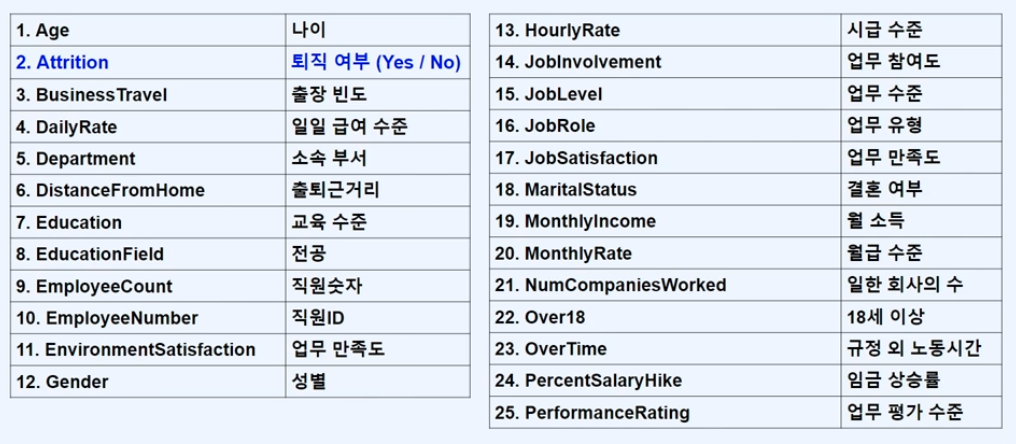   
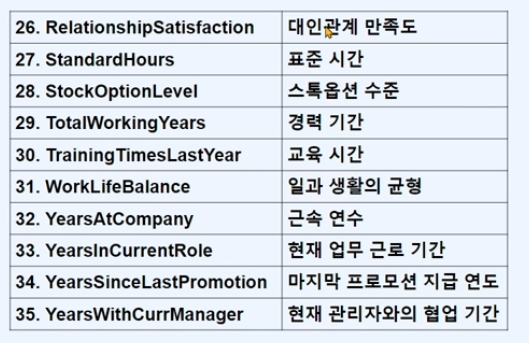  
Target Feature = Attrition

분석 목표: HR 데이터를 활용한 주요 직원 이탈 요인 분석

## 2. 데이터 준비를 위한 EDA 및 전처리

In [1]:
! apt-get update -qq
! apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = 'NanumGothic'
fe = fm.FontEntry(fname=path, name=font_name)
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': font_name})

Selecting previously unselected package fonts-nanum.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


### 1. 데이터 불러오기

In [2]:
##### 필요한 파이썬 라이브러리 불러오기 #####
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
from imblearn.over_sampling import SMOTE
import xgboost

from scipy.stats import pearsonr, chi2_contingency    # 상관성 분석 시에 숫자형 변수 간에는 pearsonr 상관 계수를 씀
from itertools import combinations
from statsmodels.stats.proportion import proportion_confint

#Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
attrition = pd.read_csv('/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/04_analyzing_reason_of_employee_leaving_with_HR_data/WA_Fn-UseC_-HR-Employee-Attrition.csv')
attrition.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
# 데이터의 모양 알아보기
print(attrition.shape)

(1470, 35)


### 2. 데이터 탐색
#### 1) 변수간 관계 시각화
##### KDE Plot
- Kunnel Density Estimator Plot
- Kunnel의 density를 plot에 나타냄

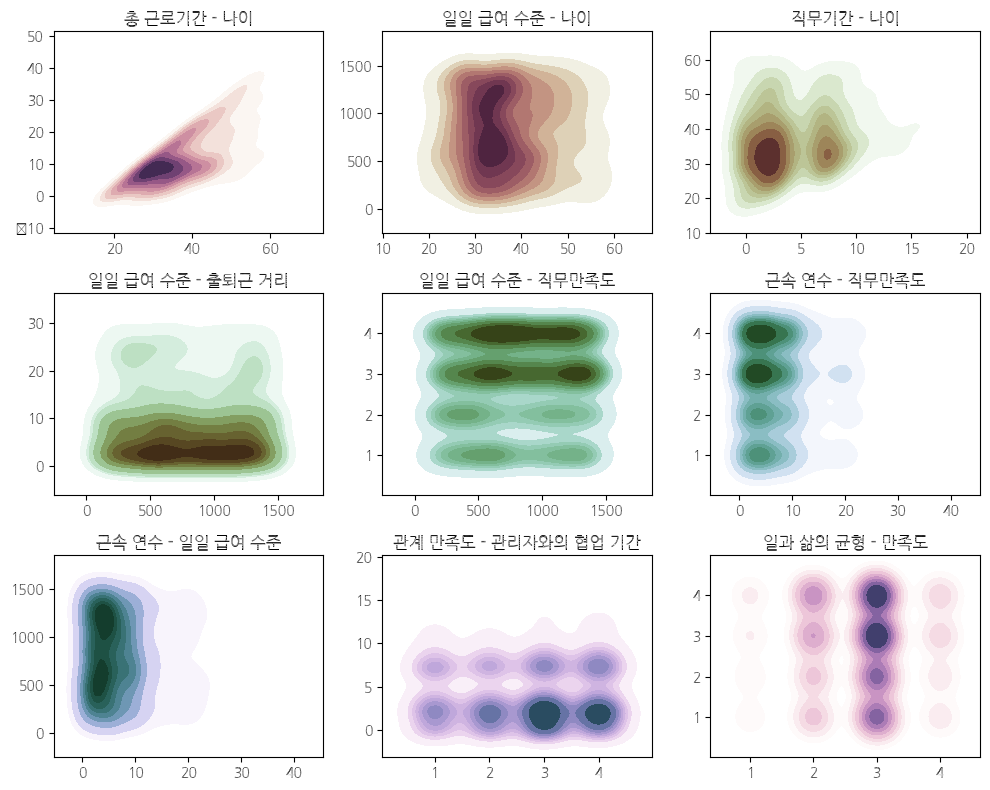

In [5]:
# 3*3 의 subplot을 그린 후에 주요 9개 변수에 대해서 서로간의 관계를 시각화

# 여러개의 KDE Plot 생성 준비
f, axes = plt.subplots(3, 3, figsize=(10, 8), sharex=False, sharey=False)

# Plot 색감 설정
s = np.linspace(0, 3, 10)
cmap = sns.cubehelix_palette(start=0.0, light=1, as_cmap=True)

x = attrition['Age'].values
y = attrition['TotalWorkingYears'].values
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=axes[0, 0])
axes[0, 0].set(title='총 근로기간 - 나이')
cmap = sns.cubehelix_palette(start=0.3333333333, light=1, as_cmap=True)

x = attrition['Age'].values
y = attrition['DailyRate'].values
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[0, 1])
axes[0, 1].set(title='일일 급여 수준 - 나이')
cmap = sns.cubehelix_palette(start=0.6666666667, light=1, as_cmap=True)

x = attrition['YearsInCurrentRole'].values
y = attrition['Age'].values
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[0, 2])
axes[0, 2].set(title='직무기간 - 나이')
cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)

x = attrition['DailyRate'].values
y = attrition['DistanceFromHome'].values
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[1, 0])
axes[1, 0].set(title='일일 급여 수준 - 출퇴근 거리')
cmap = sns.cubehelix_palette(start=1.3333333333, light=1, as_cmap=True)

x = attrition['DailyRate'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[1, 1])
axes[1, 1].set(title='일일 급여 수준 - 직무만족도')
cmap = sns.cubehelix_palette(start=1.6666666667, light=1, as_cmap=True)

x = attrition['YearsAtCompany'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[1, 2])
axes[1, 2].set(title='근속 연수 - 직무만족도')
cmap = sns.cubehelix_palette(start=2.0, light=1, as_cmap=True)

x = attrition['YearsAtCompany'].values
y = attrition['DailyRate'].values
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[2, 0])
axes[2, 0].set(title='근속 연수 - 일일 급여 수준')
cmap = sns.cubehelix_palette(start=2.3333333333, light=1, as_cmap=True)

x = attrition['RelationshipSatisfaction'].values
y = attrition['YearsWithCurrManager'].values
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[2, 1])
axes[2, 1].set(title='관계 만족도 - 관리자와의 협업 기간')
cmap = sns.cubehelix_palette(start=2.6666666667, light=1, as_cmap=True)

x = attrition['WorkLifeBalance'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[2, 2])
axes[2, 2].set(title='일과 삶의 균형 - 만족도')
cmap = sns.cubehelix_palette(start=3.0, light=1, as_cmap=True)

f.tight_layout()

### 3. 데이터 전처리
- 결측값 처리
- 중복값 처리

#### 1) 결측값 처리

In [6]:
# 결측값 확인
display(attrition.isnull().any())   # 모든게 False이므로 결측값 없음

Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesL

#### 2) 중복값 처리

In [7]:
attrition.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1465    False
1466    False
1467    False
1468    False
1469    False
Length: 1470, dtype: bool

In [8]:
# 중복된 항목 수 알아보기
print('중복된 항목 수: ', len(attrition[attrition.duplicated]))

중복된 항목 수:  0


### 데이터 타입별 Feature 변환
#### 1) Feature 탐색
총 Feature 개수 확인


In [9]:
print(attrition.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

Feature 데이터 타입별 개수 확인

In [10]:
dtype_data = attrition.dtypes.reset_index()
dtype_data.columns = ['Count', 'Column Type']
dtype_data.head()

,Count,Column Type
0,Age,int64
1,Attrition,object
2,BusinessTravel,object
3,DailyRate,int64
4,Department,object


In [11]:
# 데이터 타입별 컬럼 수 확인
dtype_data = attrition.dtypes.reset_index()
dtype_data.columns = ['Count', 'Column Type']
dtype_data = dtype_data.groupby("Column Type").aggregate('count').reset_index()

print(dtype_data)

  Column Type  Count
0       int64     26
1      object      9


#### 2) 숫자형 Feature
- 데이터 확인
- Feature 제거
- Feature Skewness 확인

데이터 확인

In [12]:
# pandas의 select_dtypes('number') 사용
attrition.select_dtypes(include=['number']).head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1102,1,2,1,1,2,94,3,2,...,1,80,0,8,0,1,6,4,0,5
1,49,279,8,1,1,2,3,61,2,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1373,2,2,1,4,4,92,2,1,...,2,80,0,7,3,3,0,0,0,0
3,33,1392,3,4,1,5,4,56,3,1,...,3,80,0,8,3,3,8,7,3,0
4,27,591,2,1,1,7,1,40,3,1,...,4,80,1,6,3,3,2,2,2,2


In [14]:
num_feat = attrition.select_dtypes(include=['number']).columns.values
attrition_num = attrition[num_feat].copy()
attrition_num

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1102,1,2,1,1,2,94,3,2,...,1,80,0,8,0,1,6,4,0,5
1,49,279,8,1,1,2,3,61,2,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1373,2,2,1,4,4,92,2,1,...,2,80,0,7,3,3,0,0,0,0
3,33,1392,3,4,1,5,4,56,3,1,...,3,80,0,8,3,3,8,7,3,0
4,27,591,2,1,1,7,1,40,3,1,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,1,2061,3,41,4,2,...,3,80,1,17,3,3,5,2,0,3
1466,39,613,6,1,1,2062,4,42,2,3,...,1,80,1,9,5,3,7,7,1,7
1467,27,155,4,3,1,2064,2,87,4,2,...,2,80,1,6,0,3,6,2,0,3
1468,49,1023,2,3,1,2065,4,63,2,2,...,4,80,0,17,3,2,9,6,0,8


Feature 제거
> Feature 별 유일한 값 개수 확인

In [19]:
# 결과가 1인 컬럼은 모두 같은 값을 가지고 있는 것이고 결과가 1470이면 사원번호처럼 모두 다른 값을 가지고 있는 것
print(attrition_num.nunique().sort_values())

StandardHours                  1
EmployeeCount                  1
PerformanceRating              2
RelationshipSatisfaction       4
EnvironmentSatisfaction        4
WorkLifeBalance                4
JobInvolvement                 4
StockOptionLevel               4
JobSatisfaction                4
JobLevel                       5
Education                      5
TrainingTimesLastYear          7
NumCompaniesWorked            10
PercentSalaryHike             15
YearsSinceLastPromotion       16
YearsWithCurrManager          18
YearsInCurrentRole            19
DistanceFromHome              29
YearsAtCompany                37
TotalWorkingYears             40
Age                           43
HourlyRate                    71
DailyRate                    886
MonthlyIncome               1349
MonthlyRate                 1427
EmployeeNumber              1470
dtype: int64


In [17]:
print(attrition.shape)

(1470, 35)


유일한 값이 1개인 경우 또는 모든 행의 값이 다른 경우는 제거  
- Target Feature가 포함되어 있으면 함께 제거

In [20]:
attrition_num = attrition_num.drop(['StandardHours', 'EmployeeCount', 'EmployeeNumber'], axis=1, errors='ignore')

Feature Skewness 확인 (피쳐의 값이 어느 쪽으로 치우쳐져있는지)

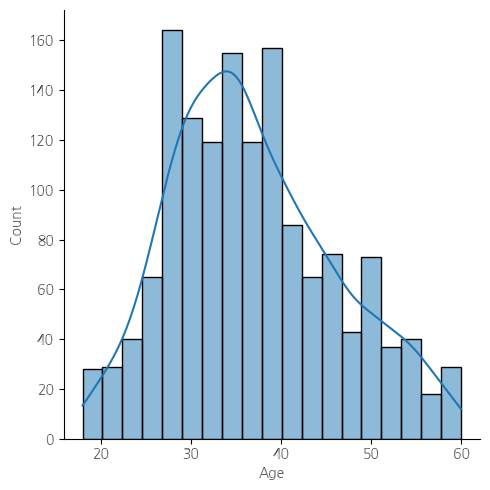

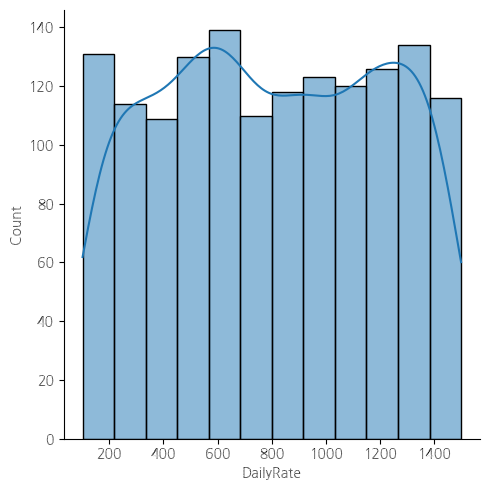

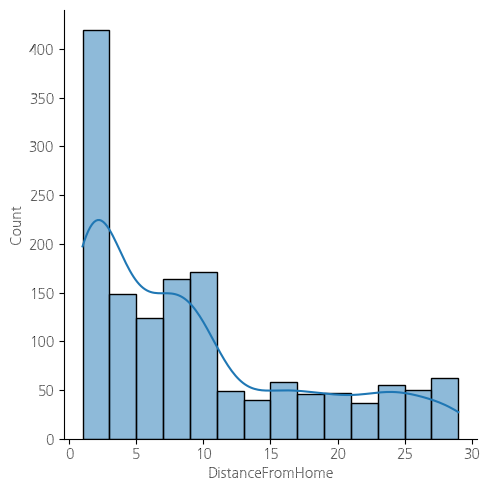

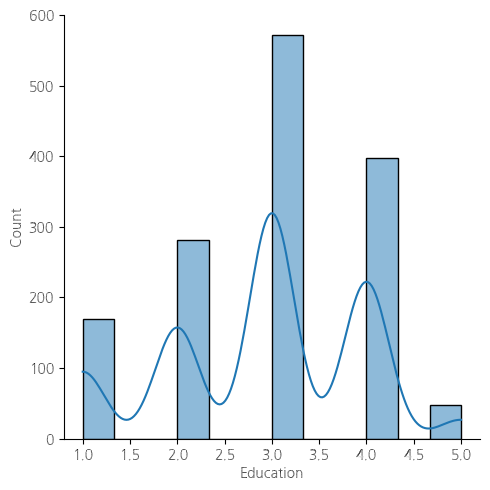

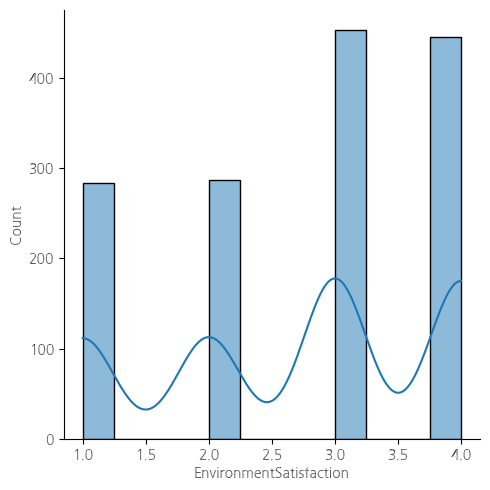

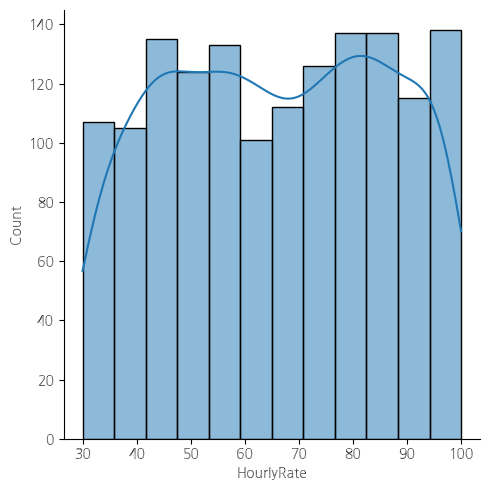

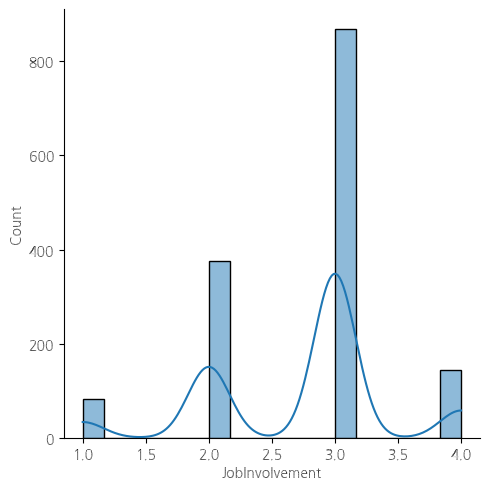

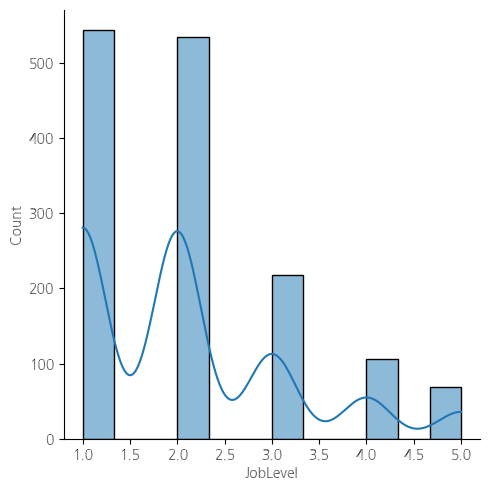

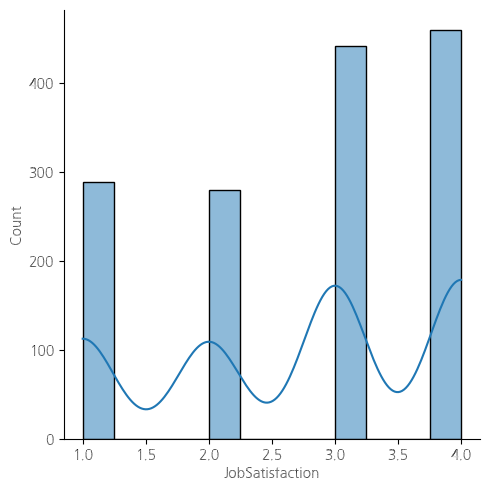

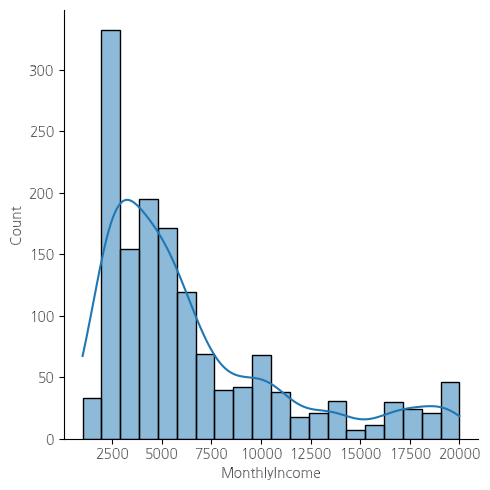

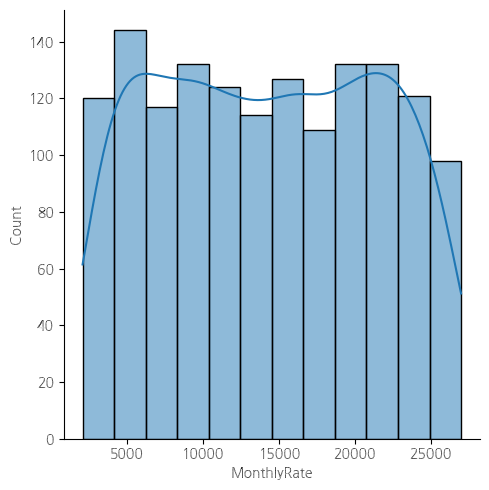

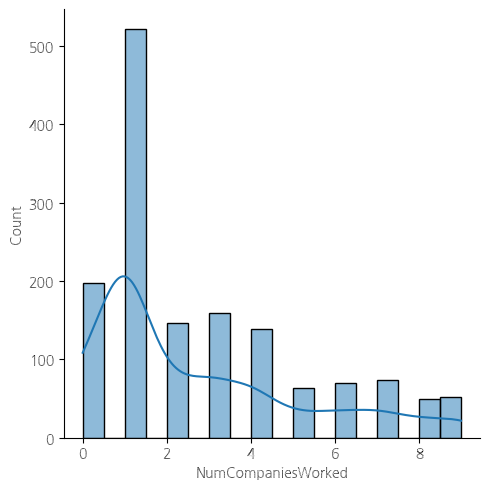

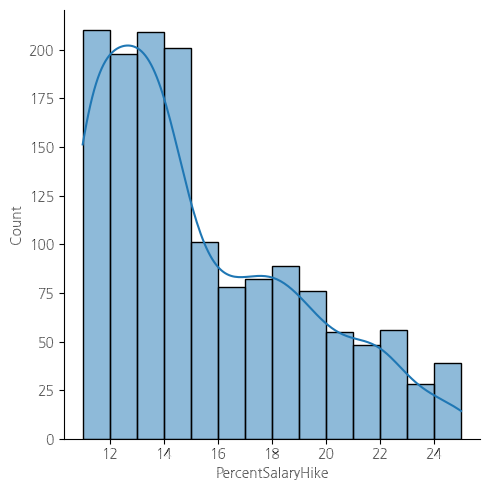

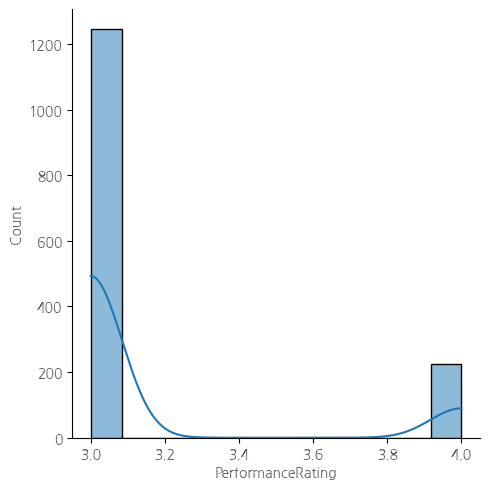

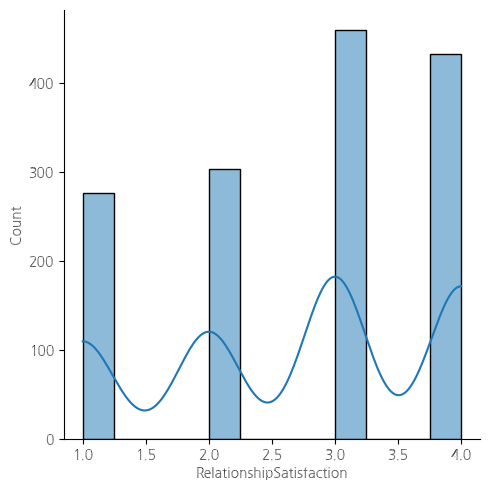

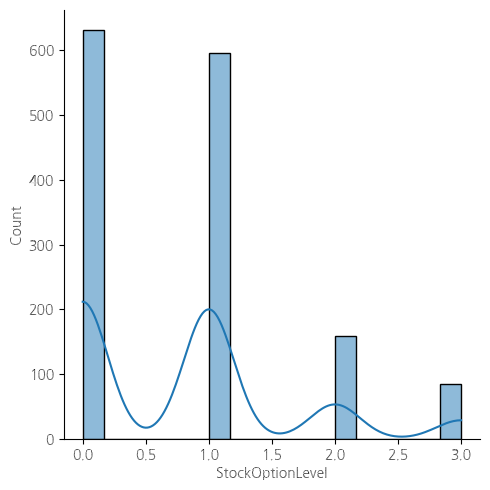

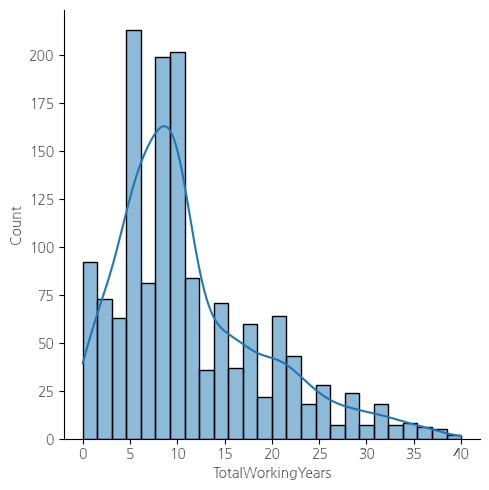

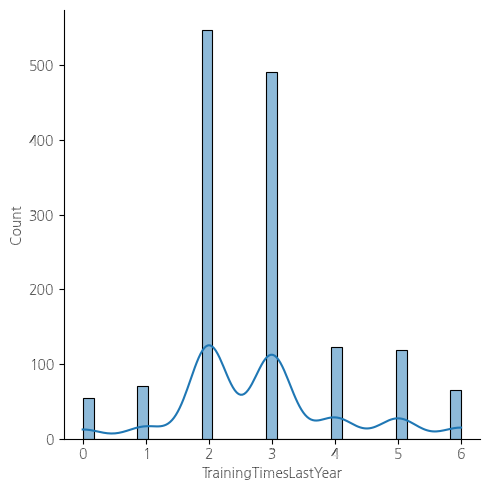

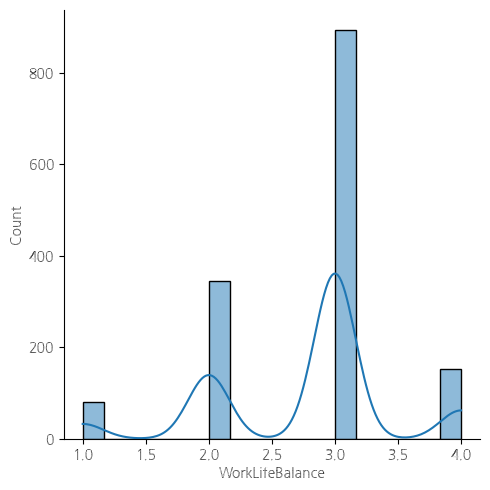

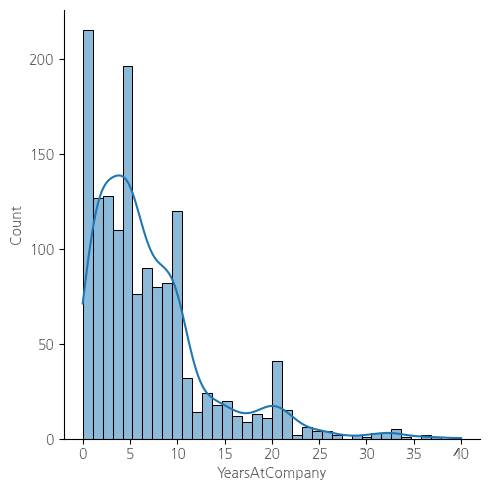

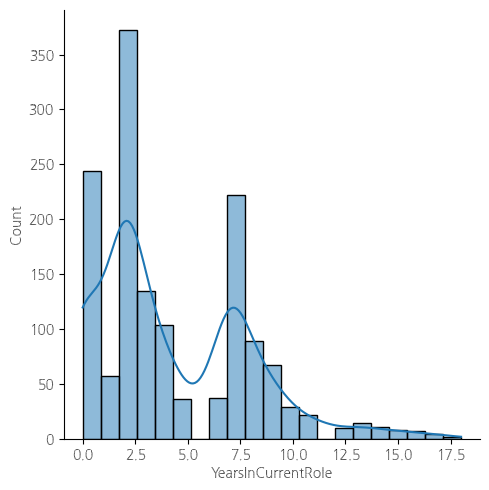

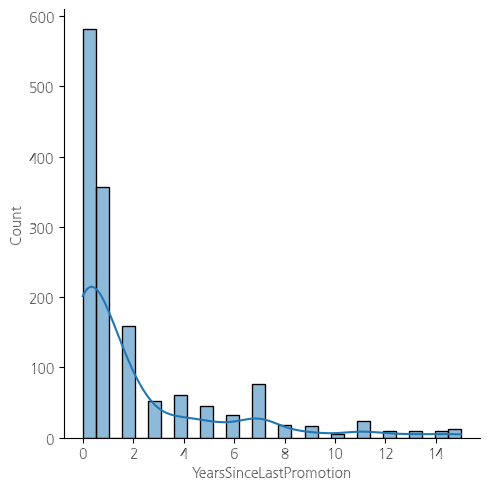

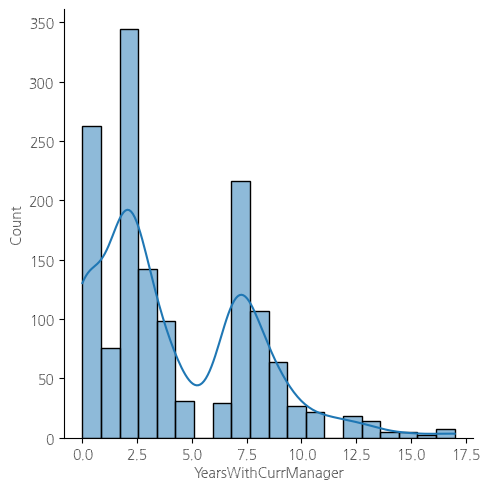

In [22]:
col_attrition_num = attrition_num.columns.values
for i in range(0, len(col_attrition_num)):
  sns.displot(attrition_num[col_attrition_num[i]], kde=True)